<a href="https://colab.research.google.com/github/bubuloMallone/NeuralNetworksEX/blob/main/mlp_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of a multilayer perceptron (MLP) charachter-level language model, trained on the names dataset already used.

Reference paper: Bengio et al. 2003

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [51]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/bubuloMallone/NeuralNetworksEX/refs/heads/main/datasets/names.txt

words = open('names.txt', 'r').read().splitlines()

words[:10]

--2025-07-09 09:42:13--  https://raw.githubusercontent.com/bubuloMallone/NeuralNetworksEX/refs/heads/main/datasets/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-07-09 09:42:13 (8.25 MB/s) - ‘names.txt’ saved [228145/228145]



['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

First let us build the vocabulary of characters and the relative mappings to/from integers

In [3]:
chars = sorted(list(set(''.join(words))))
alphabet_size = len(chars) + 1
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(alphabet_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Now let us build the dataset

In [4]:
# define the context length: how many char we consider to predict the next one
block_size = 3
X, Y = [], []

for word in words:
  # print(word)

  context = [0] * block_size
  for ch in word + '.':
    idx = stoi[ch]
    X.append(context)
    Y.append(idx)
    # print(''.join(itos[i] for i in context), '--->', itos[idx])
    context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)
print('Data:', X.shape, X.dtype)
print('Labels:', Y.shape, Y.dtype)

num_samples = X.shape[0]

Data: torch.Size([228146, 3]) torch.int64
Labels: torch.Size([228146]) torch.int64


Now let us build now te neural network. It will be a MLP consisting of an embedding layer, an internal layer and an putput layer.

In [26]:
g = torch.Generator().manual_seed(2147483647)

# embedding
emb_dim = 2
C = torch.randn((alphabet_size, emb_dim))

# first fully connected layer
hidden_dim = 100
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)

# second fully connected layer
W2 = torch.randn((hidden_dim, alphabet_size), generator=g)
b2 = torch.randn(alphabet_size, generator=g)

parameters = [C, W1, b1, W2, b2]

# require gradients
for p in parameters:
  p.requires_grad = True

tot_parameters = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {tot_parameters}')

Total number of parameters: 3481


Let us choose a good initial learning rate

In [27]:
steps = 1000
lre = torch.linspace(-3, 0, steps)
lrs = 10**lre
# plt.plot(lrs)

In [28]:
learning_rate_list = []
losses = []

for i in range(steps):

  # minibatch construct
  batch_size = 32
  idxs = torch.randint(0, num_samples, (batch_size,))   # (num_samples,) --> (batch_size,)

  # forward pass
  emb = C[X[idxs]]   # (num_samples, block_size, emb_dim) --> (batch_size, block_size, emb_dim)
  h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)   # (batch_size, hidden_dim)
  logits = h @ W2 + b2    # (batch_size, alphabet_size)
  loss = F.cross_entropy(logits, Y[idxs])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  learning_rate = lrs[i]
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  learning_rate_list.append(learning_rate)
  losses.append(loss.item())

# print(loss.item())


Text(0, 0.5, 'Loss')

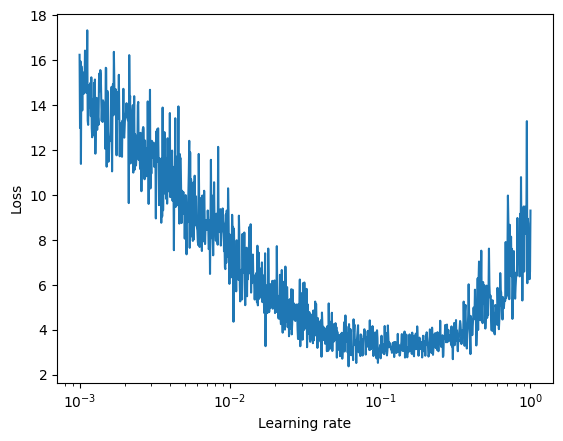

In [29]:
plt.plot(learning_rate_list, losses)
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')

Train the network with this estimate for a good learning rate ($ ≈ 10^{-1}$).

First, we need to create the training/validation/test sets from the dataset.

Training set (80%) --> optimize the weights

Validtion set (10%) --> optimize the hyperparameters

Test set (10%) --> validate the model accuracy


In [61]:
import random

In [86]:
# build the dataset

def build_dataset(words):
  # define the context length: how many char we consider to predict the next one
  block_size = 3
  X, Y = [], []

  for word in words:

    context = [0] * block_size
    for ch in word + '.':
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      # print(''.join(itos[i] for i in context), '--->', itos[idx])
      context = context[1:] + [idx]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print('Data:', X.shape, X.dtype)
  print('Labels:', Y.shape, Y.dtype)
  num_samples = X.shape[0]

  return X, Y, num_samples


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr, num_samples_tr = build_dataset(words[:n1])
Xval, Yval, num_samples_val = build_dataset(words[n1:n2])
Xte, Yte, num_samples_te = build_dataset(words[n2:])

Data: torch.Size([182580, 3]) torch.int64
Labels: torch.Size([182580]) torch.int64
Data: torch.Size([22767, 3]) torch.int64
Labels: torch.Size([22767]) torch.int64
Data: torch.Size([22799, 3]) torch.int64
Labels: torch.Size([22799]) torch.int64


In [89]:
g = torch.Generator().manual_seed(2147483647)

# embedding
emb_dim = 2
C = torch.randn((alphabet_size, emb_dim))

# first fully connected layer
hidden_dim = 300
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)

# second fully connected layer
W2 = torch.randn((hidden_dim, alphabet_size), generator=g)
b2 = torch.randn(alphabet_size, generator=g)

parameters = [C, W1, b1, W2, b2]

# require gradients
for p in parameters:
  p.requires_grad = True

tot_parameters = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {tot_parameters}')

Total number of parameters: 10281


In [102]:
steps = 30000
losses = []

for _ in range(steps):

  # minibatch construct
  batch_size = 32
  idxs = torch.randint(0, num_samples_tr, (batch_size,))   # (num_samples,) --> (batch_size,)

  # forward pass
  emb = C[Xtr[idxs]]   # (batch_size, block_size, emb_dim)
  h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)   # (batch_size, hidden_dim)
  logits = h @ W2 + b2    # (batch_size, alphabet_size)
  loss = F.cross_entropy(logits, Ytr[idxs])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  learning_rate = 0.1
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  losses.append(loss.item())

print(np.mean(losses))


2.305852673482895


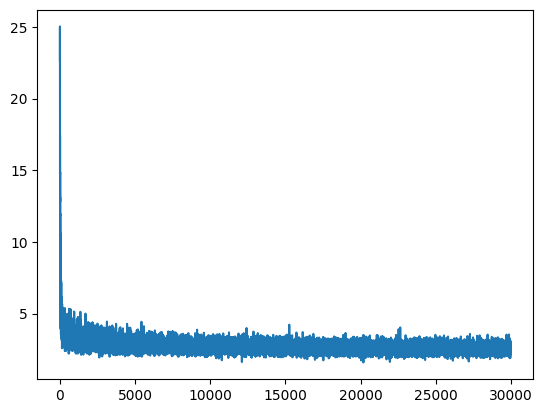

In [91]:
plt.plot(np.arange(steps), losses)

Check the Loss on the validation set

In [100]:
# forward pass
emb = C[Xval]   # (batch_size, block_size, emb_dim)
h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)   # (batch_size, hidden_dim)
logits = h @ W2 + b2    # (batch_size, alphabet_size)
loss = F.cross_entropy(logits, Yval)
print(loss.item())

2.4116063117980957


What about the embedding space ? For dim = 2 we can visualize it and get and idea of what the network is doing. THere is some sort of clustering of the characters. However the low dimension of the space might be a bottleneck for the learning ability of the network.

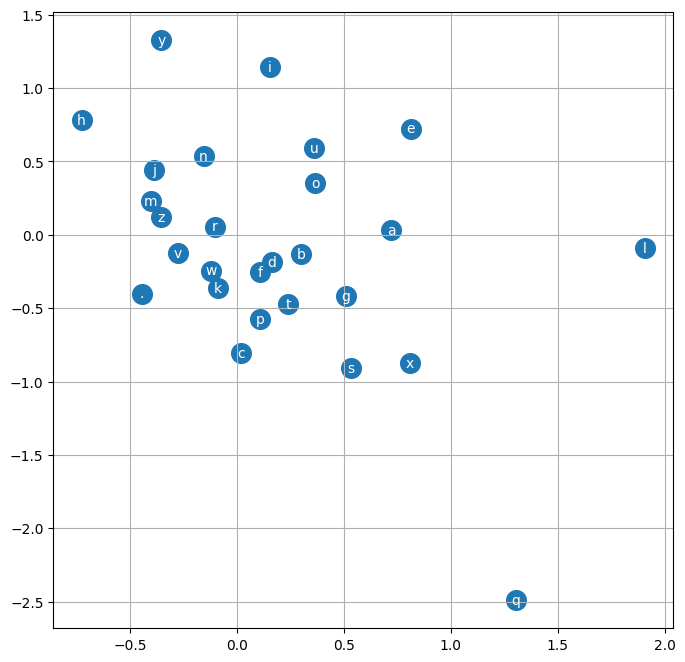

In [103]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Let us increase the embedding space dimension

In [105]:
g = torch.Generator().manual_seed(2147483647)

# embedding
emb_dim = 10
C = torch.randn((alphabet_size, emb_dim))

# first fully connected layer
hidden_dim = 200
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)

# second fully connected layer
W2 = torch.randn((hidden_dim, alphabet_size), generator=g)
b2 = torch.randn(alphabet_size, generator=g)

parameters = [C, W1, b1, W2, b2]

# require gradients
for p in parameters:
  p.requires_grad = True

tot_parameters = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {tot_parameters}')

Total number of parameters: 11897


In [124]:
losses = []

In [127]:
steps = 50000
for _ in range(steps):

  # minibatch construct
  batch_size = 32
  idxs = torch.randint(0, num_samples_tr, (batch_size,))   # (num_samples,) --> (batch_size,)

  # forward pass
  emb = C[Xtr[idxs]]   # (batch_size, block_size, emb_dim)
  h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)   # (batch_size, hidden_dim)
  logits = h @ W2 + b2    # (batch_size, alphabet_size)
  loss = F.cross_entropy(logits, Ytr[idxs])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  learning_rate = 0.01
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  losses.append(loss.item())

print(np.mean(losses))

2.1248033604240417


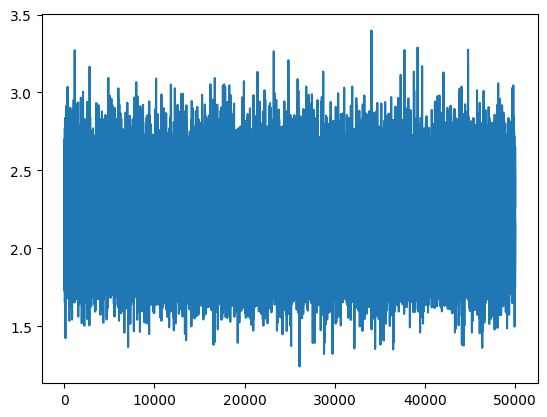

In [126]:
plt.plot(np.arange(len(losses)), losses)

How to sample from the treined model?

In [135]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size   # initialize the sampling context with "..."
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [idx]
    out.append(idx)
    if idx == 0:
      break

print(''.join(itos[i] for i in out))

naa.
